In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
"""
    Package Installation
"""
__author__ = "SakibApon"
__email__ = "sakibapon7@gmail.com"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
%matplotlib inline
import os
import re
print(os.listdir("../input"))
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, plot_confusion_matrix
# Any results you write to the current directory are saved as output.

['sarcasmdetectionprocessed']


In [21]:
df = pd.read_csv("../input/sarcasmdetectionprocessed/SarcasmDetectionProcessed.csv")
df.head()

,Unnamed: 0,Tweet,Label
0,0,I love finding out who your true friends are. ...,0
1,1,USER :/ bye,0
2,2,USER I absolutely love Kanye's voice USER,0
3,3,We're hiring a new Kiosk Supervisor! Think you...,0
4,4,Every time I see Dave Grohl with his long hipp...,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

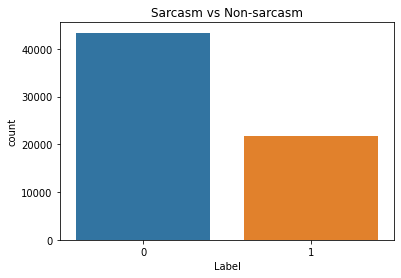

In [22]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [26]:
labels = df.Label.values
sentences = df.Tweet.values

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
    ids = []
    for sentence in sentences:
        encoding = tokenizer.encode_plus(
        sentence,
        max_length=16,
        truncation = True,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=False)
        ids.append(encoding['input_ids'])
    return ids

#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

In [30]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

2022-06-05 16:50:22.212611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:50:22.213691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:50:22.214364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:50:22.216502: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [36]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(1024, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.5)(dense)
dense = tf.keras.layers.Dense(512, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes = 1),  tf.keras.metrics.AUC()]
#callbacks
checkpoint = ModelCheckpoint('SarcasmBERT.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=0.001)
callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics = metrics)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 16)]              0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              787456    
_________________________________________________________________
dropout_114 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_115 (Dropout)        (None, 512)               0   

In [42]:
history = model.fit(x = train_ids, y = train_labels, epochs = 25, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/25
1729/1729 [==============================] - 208s 111ms/step - loss: 0.5204 - accuracy: 0.7085 - precision_3: 0.5763 - recall_3: 0.4646 - f1_score: 0.4990 - auc_2: 0.7687 - val_loss: 0.4877 - val_accuracy: 0.7254 - val_precision_3: 0.6436 - val_recall_3: 0.4182 - val_f1_score: 0.5047 - val_auc_2: 0.8040
Epoch 2/25
1729/1729 [==============================] - 190s 110ms/step - loss: 0.4697 - accuracy: 0.7367 - precision_3: 0.6066 - recall_3: 0.5914 - f1_score: 0.4990 - auc_2: 0.8155 - val_loss: 0.4793 - val_accuracy: 0.7317 - val_precision_3: 0.5958 - val_recall_3: 0.6379 - val_f1_score: 0.5047 - val_auc_2: 0.8083
Epoch 3/25
1729/1729 [==============================] - 189s 109ms/step - loss: 0.4395 - accuracy: 0.7557 - precision_3: 0.6204 - recall_3: 0.6833 - f1_score: 0.4990 - auc_2: 0.8378 - val_loss: 0.4980 - val_accuracy: 0.7096 - val_precision_3: 0.5480 - val_recall_3: 0.7976 - val_f1_score: 0.5047 - val_auc_2: 0.8034
Epoch 4/25
1729/1729 [==============================

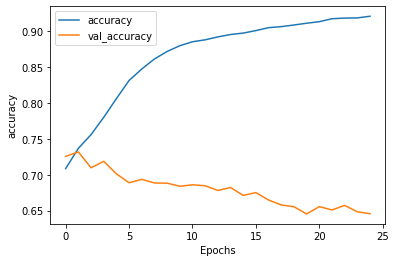

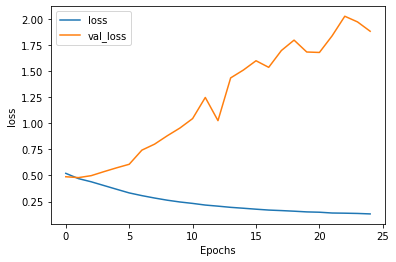

In [43]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

              precision    recall  f1-score   support

     class 0       0.66      1.00      0.80      6466
     class 1       0.00      0.00      0.00      3295

    accuracy                           0.66      9761
   macro avg       0.33      0.50      0.40      9761
weighted avg       0.44      0.66      0.53      9761



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


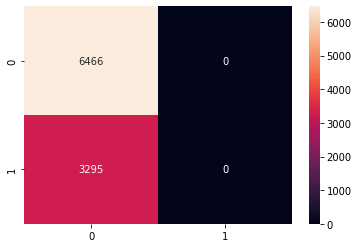

In [60]:
y_true = test_labels
y_pred = argmax(model.predict(test_ids),axis=1)

target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

              precision    recall  f1-score   support

     class 0       0.66      1.00      0.80      6466
     class 1       0.00      0.00      0.00      3295

    accuracy                           0.66      9761
   macro avg       0.33      0.50      0.40      9761
weighted avg       0.44      0.66      0.53      9761



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
test_labels

<tf.Tensor: shape=(9761,), dtype=int64, numpy=array([0, 1, 0, ..., 0, 0, 1])>